# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [2]:
#| default_exp ffp

In [26]:
#| hide
from nbdev.showdoc import *

In [175]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, dblquad, tplquad
from scipy.interpolate import interp1d, interp2d
import pickle
import functools
from pathos.multiprocessing import ProcessingPool as Pool

import functools

from fastcore.test import *
from tqdm import tqdm


In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
#| export

# Add Koshimoto Parametric MW Model
# https://iopscience.iop.org/article/10.3847/1538-4357/ac07a8/pdf

# Disk Density
def zthin(r):
    if r > 4.5:
        return zthinSol - (zthinSol - zthin45) * (rsol - r) / (rsol - 4.5)
    else:
        return zthin45

def rho_thin_mw(r, 
             z,
            ) -> float: # FFP density in Msun/kpc^3

    if r > rdBreak:
        result = rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((r - rsol) / rthin)) * \
            (1 / np.cosh(-np.abs(z) / zthin(r)))**2
    else:
        result = rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((rdBreak - rsol) / rthin)) * \
            (1 / np.cosh(-np.abs(z) / zthin(r)))**2
    
    return result 

def rho_thick_mw(r, 
              z, 
            ) -> float: # FFP density in Msun/kpc^3
    
    if r > rdBreak:
        result = rho_thick_Sol * np.exp(-((r - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))
    else:
        result = rho_thick_Sol * np.exp(-((rdBreak - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))

    return result 

# Bulge Density
def rsf(xp, yp, zp):
    rs = (((xp/x0)**cperp + (yp/y0)**cperp)**(cpar/cperp) + (zp/z0)**cpar)**(1/cpar)
    return rs

def fE(xp, yp, zp):
    return np.exp(-rsf(xp, yp, zp))

def cut(x):
    if x > 0:
        return np.exp(-x**2)
    else:
        return 1

def rho_bulge_mw(d: float,
            ) -> float: # FFP density in Msun/kpc^3
    xp, yp, zp = get_primed_coords(d)
    xp, yp, zp = abs(xp), abs(yp), abs(zp)
    r = (xp**2 + yp**2 + zp**2)**0.5
    return rho0_B * fE(xp, yp, zp) * cut((r - Rc) / 0.5)

# Total FFP Density
def rho_FFPs_mw(d: float, # distance from Sun in kpc
             ) -> float: # FFP density in Msun/kpc^3
    r = dist_mw(d)
    _, _, z = get_primed_coords(d)
    return (rho_thin_mw(r, z) + rho_thick_mw(r, z) + rho_bulge_mw(d)) 

def velocity_dispersion_stars_mw(r,
                                #  v_c: float = 30 # km/s
                                 v_c: float = 15 # km/s
                                ):
    #Take 30 km/s following table 2 of https://arxiv.org/pdf/2306.12464.pdf
    return v_c

In [137]:
test_eq(zthin(4.5), zthin45)

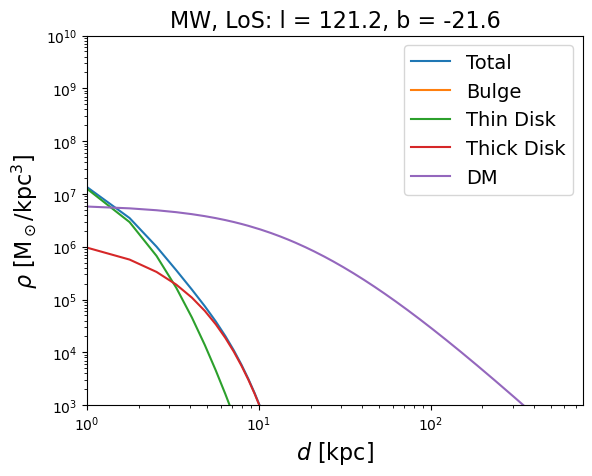

In [138]:
# Define values for the x-axis

# d_arr = np.logspace(-2, np.log10(ds), num=100)
d_arr = np.linspace(1, ds, num=1000)

z_arr = [d* np.sin(np.deg2rad(b)) for d in d_arr]
# Calculate the density values for each component
rho_total_arr = [rho_FFPs_mw(i) for i in d_arr]
rho_bulge_arr = [rho_bulge_mw(i) for i in d_arr]
rho_thin_arr = [rho_thin_mw(dist_mw(d_arr[i]), z_arr[i]) for i in range(len(d_arr))]
rho_thick_arr = [rho_thick_mw(dist_mw(d_arr[i]), z_arr[i]) for i in range(len(d_arr))]
rho_dm_arr = [density_mw(dist_mw(d_arr[i])) for i in range(len(d_arr))]

# Create the log plot
plt.plot(d_arr, rho_total_arr, label="Total")
plt.plot(d_arr, rho_bulge_arr, label="Bulge")
plt.plot(d_arr, rho_thin_arr, label="Thin Disk")
plt.plot(d_arr, rho_thick_arr, label="Thick Disk")
plt.plot(d_arr, rho_dm_arr, label="DM")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('MW, LoS: l = {}, b = {}'.format(l,b), fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xscale("log")
plt.xlim(1e0, ds)
plt.ylim(1e3, 1e10)

plt.show()


In [155]:
#| export
# Add stellar distribution of M31 following: https://www.aanda.org/articles/aa/pdf/2012/10/aa20065-12.pdf

def einasto(a, rhoc, dn, ac, n):
    return rhoc * np.exp(-dn *((a/ac)**(1/n) - 1))

def rho_bulge_m31(d, 
                ) -> float: # FFP density in Msun/kpc^3
    q = 0.72
    i = np.deg2rad(90-77)  # inclination angle of m31 disk in radians
    z = d * np.sin(i)
    r = d * np.cos(i)
    a = (r**2 + z**2/q**2)**0.5
    rhoc = 9.201e-1 * (1e3)**3 #Msun/kpc^3
    dn = 7.769
    ac = 1.155 #kpc
    n = 2.7
    return einasto(a, rhoc, dn, ac, n) 

def rho_disk_m31(d,
                    ) -> float: # FFP density in Msun/kpc^3
    q = 0.17
    i = np.deg2rad(90-77)  # inclination angle of m31 disk in radians
    z = d * np.sin(i)
    r = d * np.cos(i)
    a = (r**2 + z**2/q**2)**0.5
    rhoc = 1.307e-2 * (1e3)**3 #Msun/kpc^3
    dn = 3.273
    ac = 10.67 #kpc
    n = 1.2
    return einasto(a, rhoc, dn, ac, n) 

def rho_nucleus_m31(d,
                    ) -> float: # FFP density in Msun/kpc^3
    q = 0.99
    i = np.deg2rad(90-77)  # inclination angle of m31 disk in radians
    z = d * np.sin(i)
    r = d * np.cos(i)
    a = (r**2 + z**2/q**2)**0.5
    rhoc = 1.713 * (1e3)**3 #Msun/kpc^3
    dn = 11.668
    ac = 0.0234 #kpc
    n = 4.0
    return einasto(a, rhoc, dn, ac, n) 

def rho_FFPs_m31(d: float, # distance from center of M31 in kpc
             ) -> float: # FFP density in Msun/kpc^3
    # return (rho_bulge_m31(a) + rho_disk_m31(a) + rho_nucleus_m31(a))

    #The bulge/nucleus is excluded from the m31 survey
    if use_max_density:
        return rho_disk_m31(d) * 1.5
    return rho_disk_m31(d) 

def velocity_dispersion_stars_m31(r,
                                #  v_c: float = 60 # km/s
                                 v_c: float = 30 # km/s

                                ):
    # Use 60 km/s for disk following https://iopscience.iop.org/article/10.1088/0004-637X/695/1/442/pdf
    return v_c


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/utils.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)


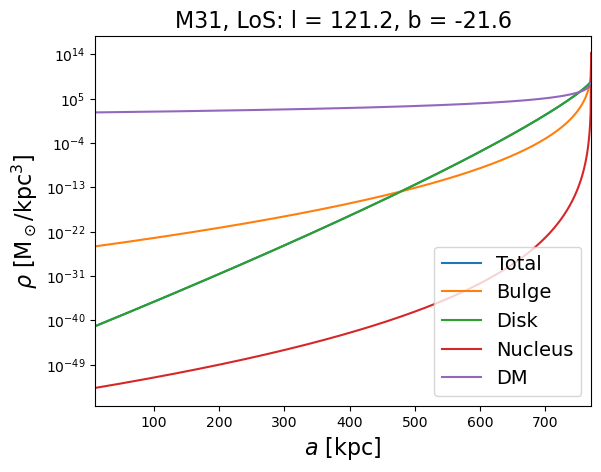

In [54]:
# Calculate the density values for each component
rho_total_arr = [rho_FFPs_m31(dist_m31(d)) for d in d_arr]
rho_bulge_arr = [rho_bulge_m31(dist_m31(d)) for d in d_arr]
rho_disk_arr = [rho_disk_m31(dist_m31(d)) for d in d_arr]
rho_nucleus_arr = [rho_nucleus_m31(dist_m31(d)) for d in d_arr]
rho_dm_arr = [density_m31(dist_m31(d)) for d in d_arr]

# Create the log plot
plt.plot(d_arr, rho_total_arr, label="Total")
plt.plot(d_arr, rho_bulge_arr, label="Bulge")
plt.plot(d_arr, rho_disk_arr, label="Disk")
plt.plot(d_arr, rho_nucleus_arr, label="Nucleus")
plt.plot(d_arr, rho_dm_arr, label="DM")

# Add labels and legend
plt.xlabel(r"$a$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('M31, LoS: l = {}, b = {}'.format(l,b), fontsize=16)

plt.legend(fontsize=14)

plt.yscale("log")
# plt.xscale("log")
plt.xlim(1e1, ds)

# Show the plot
plt.show()

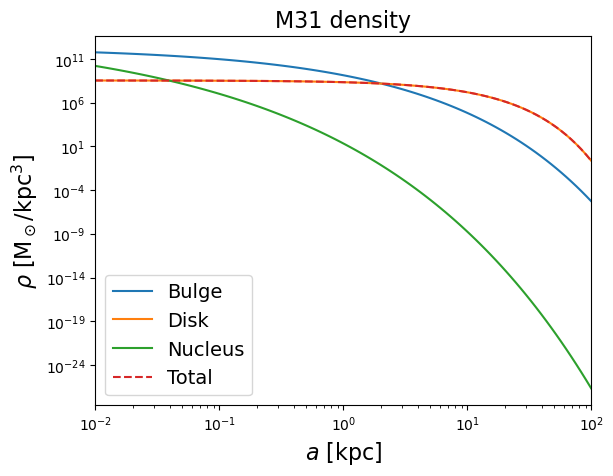

In [55]:
# Calculate the density values for each component
a_arr = np.logspace(-2, 2, 100)
rho_total_arr = [rho_FFPs_m31(a) for a in a_arr]
rho_bulge_arr = [rho_bulge_m31(a) for a in a_arr]
rho_disk_arr = [rho_disk_m31(a) for a in a_arr]
rho_nucleus_arr = [rho_nucleus_m31(a) for a in a_arr]
rho_dm_arr = [density_m31(a) for a in a_arr]

# Create the log plot
plt.plot(a_arr, rho_bulge_arr, label="Bulge")
plt.plot(a_arr, rho_disk_arr, label="Disk")
plt.plot(a_arr, rho_nucleus_arr, label="Nucleus")
plt.plot(a_arr, rho_total_arr, label="Total", ls='--')

# plt.plot(a_arr, rho_dm_arr, label="DM")

# Add labels and legend
plt.xlabel(r"$a$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('M31 density', fontsize=16)

plt.legend(fontsize=14)

plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-2, 1e2)

# Show the plot
plt.show()

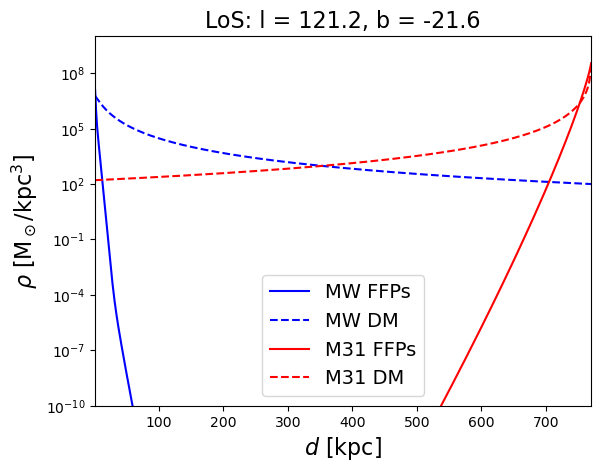

In [56]:
# Define values for the x-axis

# d_arr = np.logspace(-2, np.log10(ds*0.999), num=100)

# Calculate the density values for each component
rho_ffp_mw = [rho_FFPs_mw(i) for i in d_arr]
rho_ffp_m31 = [rho_FFPs_m31(dist_m31(i)) for i in d_arr]
rho_dm_mw = [density_mw(dist_mw(i)) for i in d_arr]
rho_dm_m31 = [density_m31(dist_m31(i)) for i in d_arr]

# Create the log plot
plt.plot(d_arr, rho_ffp_mw, label="MW FFPs", color="blue")
plt.plot(d_arr, rho_dm_mw, label="MW DM", color="blue", linestyle="--")
plt.plot(d_arr, rho_ffp_m31, label="M31 FFPs", color="red")
plt.plot(d_arr, rho_dm_m31, label="M31 DM", color="red", linestyle="--")
# plt.plot(d_arr, rho_total_arr, label="FFPs")
# plt.plot(d_arr, rho_dm_arr, label="DM")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('LoS: l = {}, b = {}'.format(l,b), fontsize=16)

plt.legend(fontsize=14)

plt.yscale("log")
# plt.xscale("log")
plt.xlim(1e0, ds)
plt.ylim(1e-10, 1e10)

# Show the plot
plt.show()

In [200]:
#| export
class Ffp(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                p: float = 1, # Mass function power law index
                m_min: float = 1e-15, # Minimum mass in Msun
                # m_max: float = 1e-5, # Maximum mass in Msun
                m_max: float = 1e-3, # Maximum mass in Msun
                use_mw_source: bool = False,
                ):
        """
        Initialize the PBH population
        """
        
        if use_mw_source:
            self.ut_interp = ut_interp_mw #assuming source is 8.5 kpc away
        else:
            self.ut_interp = ut_interp # assuming source is in m31, 770 kpc away
        # self.ut_interp = ut_interp_mw

        self.p = p
        #Define range of power law we want to consider
        self.m_min = m_min
        self.m_max = m_max
        self.M_norm = 1 #solar mass
        # self.Z = self.pl_norm(self.p)
        self.Z = self.pl_norm_new()

    def __str__(self) -> str:
        return f"FFP with power law dN / dlogM ~ m^-{self.p}"
    __repr__ = __str__

    # def mass_func(self, m):
    #     #M_norm = 1 solar mass for now
    #     return (m / 1) ** -self.p

    def dN_dM(self, A, M, M_norm, p):
        return A * (M/M_norm)**-p / M
    
    def dN_dM_wrapper(self, M):
        return self.dN_dM(1, M, self.M_norm, self.p)
    
    def dN_dlogM(self, A, log10M, M_norm, p):
        M = 10**log10M
        return A * (M/self.M_norm)**-p
    
    def dN_dlogM_wrapper(self, M):
        return self.dN_dlogM(1, M, self.M_norm, self.p)
    
    # def pl_norm_new(self, p):
    #     return 1/abs(nquad(self.dN_dM_wrapper,[[self.m_min, self.m_max]], opts={'points': [self.m_min, self.m_min*1e3]})[0])

    def pl_norm_new(self):
        return 1/abs(nquad(self.dN_dlogM_wrapper,[[np.log10(self.m_min), np.log10(self.m_max)]], opts={'points': [np.log10(self.m_min), np.log10(self.m_min*1e3)]})[0])
    
    # def mass_func(self, m):
    #     #M_norm = 1 solar mass for now
    #     return self.Z * (m/1)**-self.p / m

    def mass_func(self, log10m):
        #M_norm = 1 solar mass for now. This is dN/dlogM
        m = 10**log10m
        return self.Z * (m/1)**-self.p
    
    def pl_norm(self, p):
        N_ffp = 1 # Number of FFPs per star
        return N_ffp/abs(nquad(self.mass_func,[[self.m_min, self.m_max]], opts={'points': [self.m_min, self.m_min*1e3]})[0])

    def differential_rate_integrand(self, umin, d, mf, t, dist_func, density_func, v_disp_func, finite=False, density_func_uses_d=False):
        r = dist_func(d)
        ut = self.umin_upper_bound(d, mf) if (self.ut_interp and finite) else 1
        if ut <= umin:
            return 0
        v_rad = velocity_radial(d, mf, umin, t * htosec, ut)  
        v_disp = v_disp_func(r)
        density_input = d if density_func_uses_d else r
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                        #For FFP number density, use stellar density for 1 solar mass stars
                density_func(density_input) / (1 * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)

    def differential_rate(self, t, integrand_func, finite=False):
        num = 40  # number of discretization points, empirically, result levels off for >~ 40
        # mf_values = np.logspace(np.log10(self.m_min), np.log10(self.m_max), num=num)
        mf_values = np.linspace(np.log10(self.m_min), np.log10(self.m_max), num=num)

        result = 0
        for i in range(num):
            mf = mf_values[i]
            if i == 0:  # for the first point
                dm = mf_values[i+1] - mf_values[i]
            elif i < num - 1:  # for middle points
                dm = ((mf_values[i+1] - mf_values[i]) + (mf_values[i] - mf_values[i-1])) / 2
            else:  # for the last point
                dm = mf_values[i] - mf_values[i-1]
            if finite:
                single_result, error = dblquad(integrand_func, 
                                            0, ds, 
                                            lambda d: 0, 
                                            lambda d: self.umin_upper_bound(d, 10**mf),
                                            # args=(mf, t),
                                            args=(10**mf, t),

                                            # epsabs=0,
                                            # epsrel=1e-2,
                                            )
            else:
                single_result, error = dblquad(integrand_func,
                                               #Without finite size effects, integral blows up at M31 center
                                            0, ds*0.99,
                                            lambda d: 0, 
                                            lambda d: ut,
                                            args=(10**mf, t),
                                            # epsabs=0,
                                            # epsrel=1e-2,
                                            )
            # if single_result != 0 and error/abs(single_result) >=1:
                # print("Warning: error in differential rate integration is large: {}".format(error/abs(single_result)))

            # result += single_result * (mf ** -self.p) * dm  # multiply by mass function and by dm
            # result += single_result * (mf ** -self.p) / mf * dm  # multiply by mass function and by dm
            # print(10**mf, single_result* ((10**mf/1) ** -self.p) * dm)
            
            result += single_result * ((10**mf/1) ** -self.p) * dm # multiply by mass function and by dlogm. This is for dN/dlogM

        result *= self.Z  # normalization
        return result
    
    def differential_rate_monochromatic(self, t, integrand_func, finite=False, m=1e-10):
    
        if finite:
            result, error = dblquad(integrand_func, 
                                        0, ds, 
                                        lambda d: 0, 
                                        lambda d: self.umin_upper_bound(d, m),
                                        args=(m, t),
                                        )
        else:
            result, error = dblquad(integrand_func,
                                            #Without finite size effects, integral blows up at M31 center
                                        0, ds*0.99,
                                        lambda d: 0, 
                                        lambda d: ut,
                                        args=(m, t),
                                        )
        return result
        
    def differential_rate_integrand_mw(self, umin, d, mf, t, finite=False, vel_func = velocity_dispersion_stars_mw):
        return self.differential_rate_integrand(umin, d, mf, t, dist_mw, rho_FFPs_mw, vel_func, finite=finite, density_func_uses_d=True)
        
    def differential_rate_mw(self, t, finite=False, v_disp = 30):
        f = functools.partial(self.differential_rate_integrand_mw, vel_func = lambda r: v_disp)
        return self.differential_rate(t, f, finite=finite)
        # return self.differential_rate(t, self.differential_rate_integrand_mw, finite=finite)
    
    def differential_rate_mw_monochromatic(self, t, finite=False, m=1e-10):
        return self.differential_rate_monochromatic(t, self.differential_rate_integrand_mw, finite=finite, m=m)

    def differential_rate_integrand_m31(self, umin, d, mf, t, finite=False, vel_func = velocity_dispersion_stars_m31):
        return self.differential_rate_integrand(umin, d, mf, t, dist_m31, rho_FFPs_m31, vel_func , finite=finite, density_func_uses_d=False)

    def differential_rate_m31(self, t, finite=False, v_disp = 60):
        f = functools.partial(self.differential_rate_integrand_m31, vel_func = lambda r: v_disp)
        return self.differential_rate(t, f, finite=finite)
        # return self.differential_rate(t, self.differential_rate_integrand_m31, finite=finite)
    
    def differential_rate_m31_monochromatic(self, t, finite=False, m=1e-10):
        return self.differential_rate_monochromatic(t, self.differential_rate_integrand_m31, finite=finite, m=m)

    def umin_upper_bound(self, d, m):
        if self.ut_interp is None:
            self.make_ut_interp()
        return self.ut_interp(d, m)[0]
    
    def differential_rate_total(self, t, finite=False):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

In [201]:
p = 0.9
f = Ffp(p)
ts = np.logspace(-2, 1, num=20)
f

FFP with power law dN / dlogM ~ m^-0.9

In [183]:
diff_rates_finite_mw = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw.append(f.differential_rate_mw(t, finite=True))

diff_rates_finite_m31 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31.append(f.differential_rate_m31(t, finite=True))

Computing differential rates for MW (finite=True): 100%|██████████| 20/20 [01:09<00:00,  3.50s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


In [202]:
diff_rates_finite_mw_60 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_60.append(f.differential_rate_mw(t, finite=True, v_disp=60))

diff_rates_finite_m31_120 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_120.append(f.differential_rate_m31(t, finite=True, v_disp=120))

Computing differential rates for MW (finite=True): 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


In [204]:
diff_rates_finite_mw_15 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_15.append(f.differential_rate_mw(t, finite=True, v_disp=15))

diff_rates_finite_m31_30 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_30.append(f.differential_rate_m31(t, finite=True, v_disp=30))

Computing differential rates for MW (finite=True): 100%|██████████| 20/20 [01:03<00:00,  3.16s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


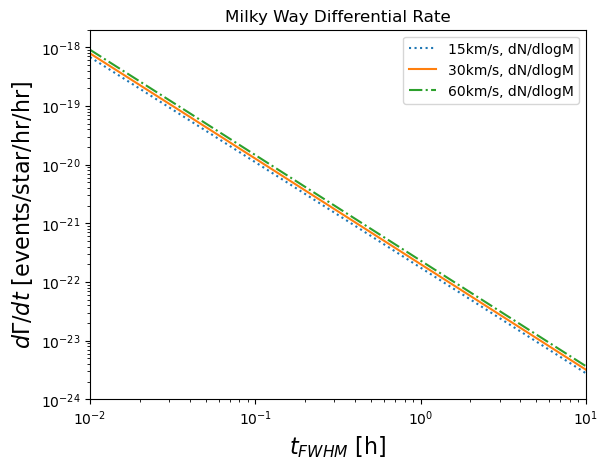

In [205]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw_15), label="15km/s, dN/dlogM", linestyle=':')
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw), label="30km/s, dN/dlogM", linestyle='-')
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw_60), label="60km/s, dN/dlogM", linestyle='-.')

plt.xlabel(r"$t_{FWHM}$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title('Milky Way Differential Rate')
plt.xlim(min(ts), max(ts))
plt.ylim(1e-24,2e-18)
plt.legend()
plt.show()

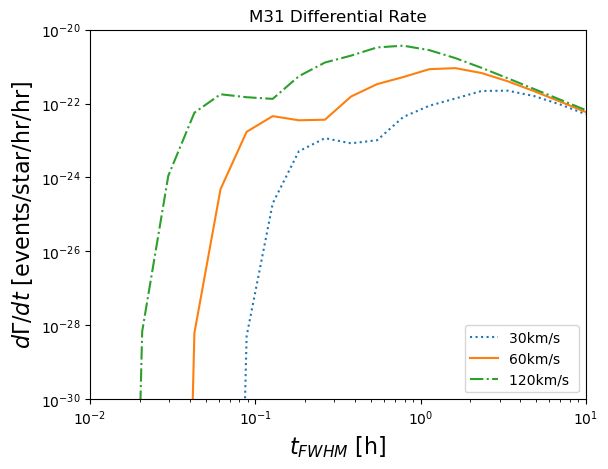

In [206]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31_30), label="30km/s ", linestyle=':')
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31), label="60km/s ", linestyle='-')
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31_120), label="120km/s ", linestyle='-.')

plt.xlabel(r"$t_{FWHM}$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title('M31 Differential Rate')
plt.xlim(min(ts), max(ts))
plt.ylim(1e-30,1e-20)
plt.legend()
plt.show()

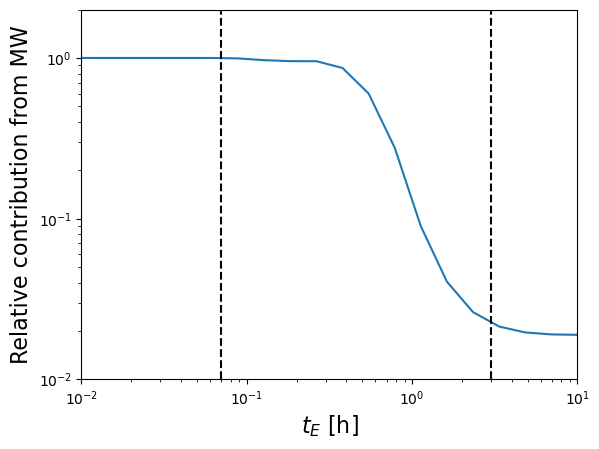

In [89]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw)/(np.array(diff_rates_finite_mw) + np.array(diff_rates_finite_m31)))
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel("Relative contribution from MW", fontsize=16)
plt.xlim(min(ts), max(ts))
plt.ylim(1e-2,2)
plt.xlim(1e-2,1e1)

plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')

plt.show()

In [165]:
interp_mw = interp1d(ts,diff_rates_finite_mw)
interp_m31 = interp1d(ts,diff_rates_finite_m31)

interp_mw_15 = interp1d(ts, diff_rates_finite_mw_15)
interp_mw_60 = interp1d(ts, diff_rates_finite_mw_60)

interp_m31_30 = interp1d(ts,diff_rates_finite_m31_30)
interp_m31_120 = interp1d(ts,diff_rates_finite_m31_120)

In [167]:
print(quad(lambda t: interp_mw_15(t), 0.07, 3)[0]+(quad(lambda t: interp_m31_30(t), 0.07, 3)[0]))
print(quad(lambda t: interp_mw(t), 0.07, 3)[0]+(quad(lambda t: interp_m31(t), 0.07, 3)[0]))
print(quad(lambda t: interp_mw_60(t), 0.07, 3)[0]+(quad(lambda t: interp_m31_120(t), 0.07, 3)[0]))

2.1898788557653654e-21
3.3161898624023574e-21
7.676589003352855e-21


In [170]:
print(quad(lambda t: interp_mw_15(t), 0.07, 3)[0])
print(quad(lambda t: interp_mw(t), 0.07, 3)[0])
print(quad(lambda t: interp_mw_60(t), 0.07, 3)[0])

1.8291744288315538e-21
2.1294626752347026e-21
2.447463651553429e-21


In [171]:
print(quad(lambda t: interp_m31_30(t), 0.07, 3)[0])
print(quad(lambda t: interp_m31(t), 0.07, 3)[0])
print(quad(lambda t: interp_m31_120(t), 0.07, 3)[0])

3.6070442693381173e-22
1.1867271871676548e-21
5.229125351799426e-21


In [90]:
interp_mw = interp1d(ts,diff_rates_finite_mw)
interp_m31 = interp1d(ts,diff_rates_finite_m31)

print(quad(lambda t: interp_mw(t), 0.07, 3)[0]/(quad(lambda t: interp_m31(t), 0.07, 3)[0] + quad(lambda t: interp_mw(t), 0.07, 3)[0]))


0.35645573993854074


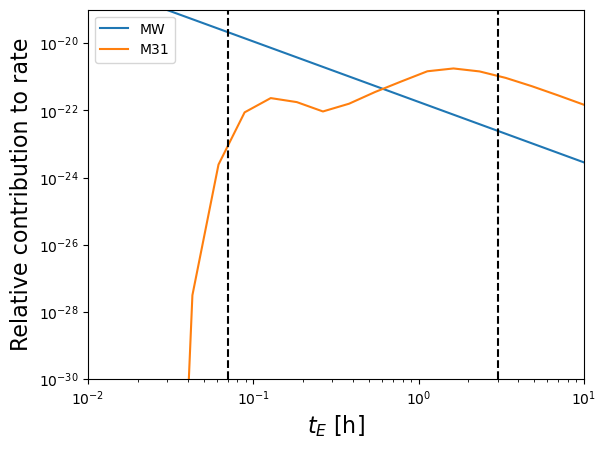

In [92]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw), label="MW")
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31), label="M31")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel("Relative contribution to rate", fontsize=16)
plt.xlim(min(ts), max(ts))
plt.xlim(1e-2,1e1)
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')

plt.ylim(1e-30,1e-19)
plt.legend()
plt.show()

In [122]:
m_test = 1e-8

diff_rates_monochromatic_m31 = []
for t in tqdm(ts, desc='Computing differential rates (finite=True)'):
    diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m_test))

diff_rates_monochromatic_mw = []
for t in tqdm(ts, desc='Computing differential rates (finite=True)'):
    diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m_test))
    

Computing differential rates (finite=True): 100%|██████████| 30/30 [00:01<00:00, 17.18it/s]


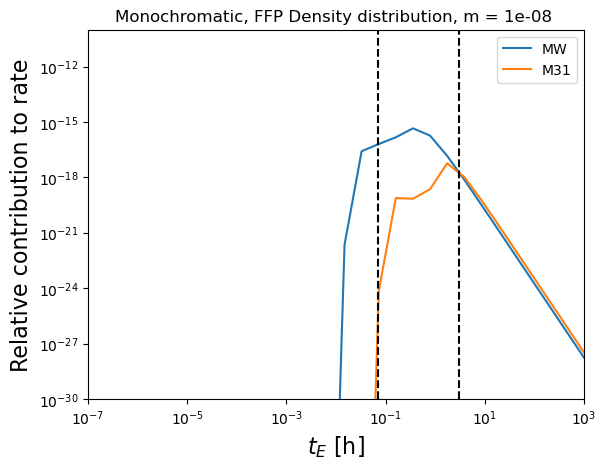

In [123]:
plt.loglog(np.array(ts), np.array(diff_rates_monochromatic_mw), label="MW")
plt.loglog(np.array(ts), np.array(diff_rates_monochromatic_m31), label="M31")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel("Relative contribution to rate", fontsize=16)
plt.xlim(min(ts), max(ts))
plt.title('Monochromatic, FFP Density distribution, m = {} '.format(m_test))
plt.ylim(1e-30,1e-10)

plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')

plt.legend()
plt.show()

In [94]:
def monochromatic_rate_ffp(m, p):

    ti = 0.07
    tf = 3

    f = Ffp(p)
    ts = np.logspace(-3, 1, num=40)
    diff_rates_monochromatic_m31 = []
    diff_rates_monochromatic_mw = []
    for t in ts:
        diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m))
        diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m))
    
    diff_interp_m31 = interp1d(ts, diff_rates_monochromatic_m31)
    diff_interp_mw = interp1d(ts, diff_rates_monochromatic_mw)

    quad_m31 = quad(diff_interp_m31, ti, tf)[0]
    quad_mw = quad(diff_interp_mw, ti, tf)[0]

    return quad_m31 + quad_mw

In [95]:
m_arr = np.logspace(-12, -2, num=30)
rates = []
p = 1
for m in tqdm(m_arr, desc='Computing differential rates (finite=True)'):
    rates.append(monochromatic_rate_ffp(m, p))

Computing differential rates (finite=True): 100%|██████████| 30/30 [01:40<00:00,  3.36s/it]


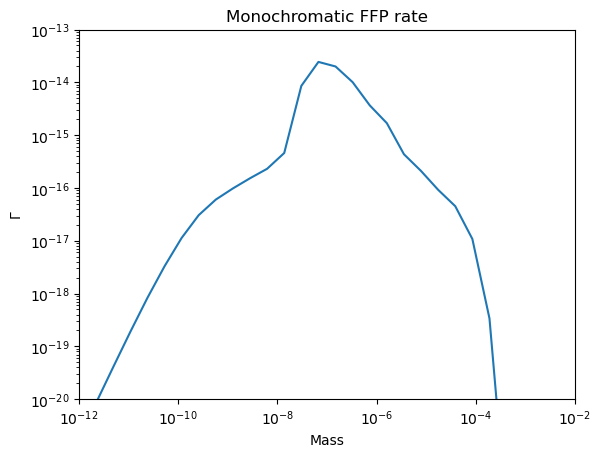

In [97]:
plt.plot(m_arr, rates)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mass")
plt.ylabel(r"$\Gamma$")
plt.title("Monochromatic FFP rate")

plt.xlim(min(m_arr), max(m_arr))
plt.ylim(1e-20, 1e-13)
plt.show()


In [98]:
#Test that the mass function is normalized correctly
# test_close(abs(nquad(f.mass_func,[[f.m_min, f.m_max]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e5]})[0]), 1, eps=1e-3)
test_close(abs(nquad(f.mass_func,[[np.log10(f.m_min), np.log10(f.m_max)]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e5]})[0]), 1, eps=1e-3)


In [100]:
ts = np.logspace(-7, np.log10(1e3), num=30)

diff_rates = []
for t in tqdm(ts, desc='Computing differential rates (finite=False)'):
    diff_rates.append(f.differential_rate_total(t, finite=False))

diff_rates_finite = []
for t in tqdm(ts, desc='Computing differential rates (finite=True)'):
    diff_rates_finite.append(f.differential_rate_total(t, finite=True))

Computing differential rates (finite=True): 100%|██████████| 30/30 [01:21<00:00,  2.71s/it]


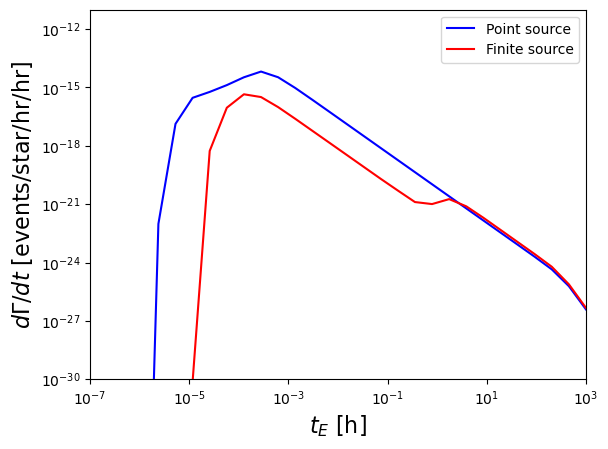

In [108]:
#new
plt.loglog(ts, diff_rates, color="blue", label="Point source")
plt.loglog(ts, diff_rates_finite, color="red", label="Finite source")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
# plt.xlim([0.009, 1e3])
plt.ylim([1e-30, 1e-11])
plt.xlim(min(ts), max(ts))
plt.legend()
plt.show()

In [109]:
def crossing_time(m, d):
    #rough crossing time in hours
    return 0.5* (m/1e-8)**(0.5) * (d/100)**0.5

In [110]:
print(scientific_format(crossing_time(1e-15, 100),1))
#So it makes sense the rate is peaked for t~1e-4 hours since that is the crossing time for the smallest mass, which contributes the most

$1.6 \times 10^{-4}$


In [111]:
#Lower HSC Sensitivity is about 7e-2 hours, this corresponds to masses of ~2e-10
print(scientific_format(crossing_time(2e-10, 100),1))

$7.1 \times 10^{-2}$


### Ensure limits are independent of mass function start/end

In [99]:
def get_n_events(A, alpha=2, finite=False, m_min=1e-15):
    #Now A is number of FFPs per star
    f = Ffp(alpha, m_min=m_min)
    ti = 0.07
    tf = 3
    t_es = np.logspace(-2, 1, num=20)
    diff_rates = f.compute_differential_rate(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return n_sources*efficiency*dnds*obsTime*A

def get_constraint_iso(m_iso, alpha=2, finite=False, m_min=1e-15):
    f = Ffp(alpha, m_min=m_min)

    if m_iso < f.m_min:
        raise ValueError('Mass must be greater than the minimum mass of the FFP mass function')
    
    n_events = get_n_events(1, alpha=alpha, finite=finite, m_min=m_min)

    #Porportion of ISOs above threshold
    proportion_above_threshold = nquad(f.mass_func,[[m_iso, f.m_max]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e5]})[0]*f.Z

    #Maximum number of total allowed ISOs per star
    N_thresh = 4.74/n_events

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_thresh * proportion_above_threshold    

In [ ]:
m_mins = np.logspace(-15, -7, num=24)

def get_constraint_iso_wrapped(m_min):
    return get_constraint_iso(1e-7, alpha=2, finite=True, m_min=m_min)

with Pool() as p:
   isos_per_star_arr = list(tqdm(p.imap(get_constraint_iso_wrapped, m_mins), total=len(m_mins)))

100%|██████████| 20/20 [06:52<00:00, 20.64s/it]


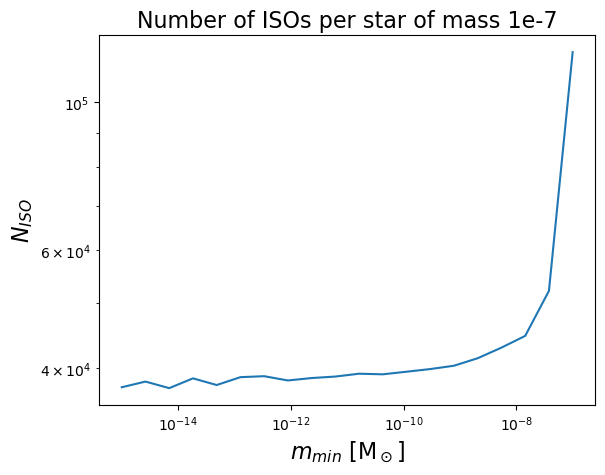

In [ ]:
# Expect to see that results are independent of m_min until the cutoff is in the range that HSC is sensitive to
# Looks good!
plt.plot(m_mins, isos_per_star_arr)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e7, 1e8)
plt.xlabel(r"$m_{min}$ [M$_\odot$]", fontsize=16)
plt.ylabel(r"$N_{ISO}$", fontsize=16)
plt.title('Number of ISOs per star of mass 1e-7', fontsize=16)
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()